# Imports

In [1]:
!pip install -U vit-keras

In [2]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [3]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from vit_keras import vit

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 21 14:26:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!mkdir /content/dataset

In [7]:
!unzip '/content/drive/MyDrive/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (8).jp

# Hyperparameters Setup

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 100

# Model Setup

In [9]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 657,
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


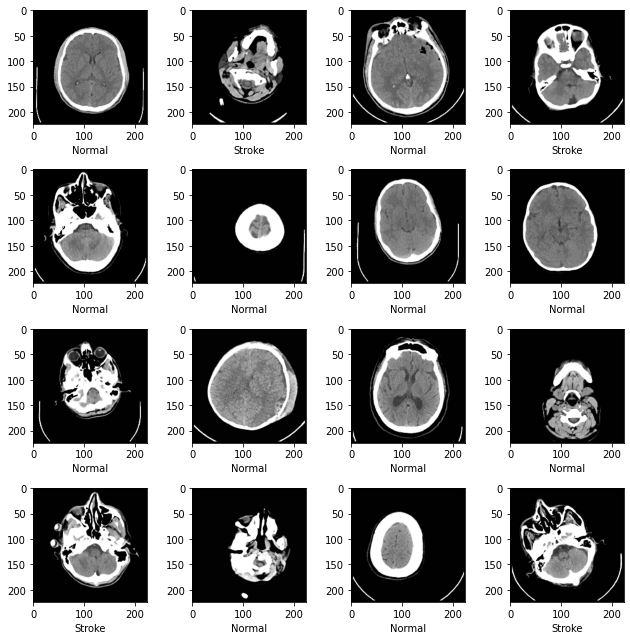

In [10]:
# show images from dataset
images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

In [12]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# DenseNet121

## Build Model

In [13]:
# create DenseNet121 base model
base_model = tf.keras.applications.DenseNet121(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [14]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [15]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('dense121')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 14:28:23.700425
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.5526 - tp: 393.0000 - fp: 192.0000 - tn: 949.0000 - fn: 267.0000 - BinaryAccuracy: 0.7451 - precision: 0.6718 - recall: 0.5955 - auc: 0.7896
Epoch 00001: val_loss improved from inf to 6.31714, saving model to model.dense121.h5
57/57 [==============================] - 50s 324ms/step - loss: 0.5526 - tp: 393.0000 - fp: 192.0000 - tn: 949.0000 - fn: 267.0000 - BinaryAccuracy: 0.7451 - precision: 0.6718 - recall: 0.5955 - auc: 0.7896 - val_loss: 6.3171 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4860 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.2882 - tp: 541.0000 - fp: 95.0000 - tn: 1046.0000 - fn: 119.0000 - BinaryAccuracy: 0.8812 - precision: 0.8506 - recall: 0.8197 - auc: 0.9461
Epoch 00002: val_loss improved from 6.31714 

## Evaluate Model

In [16]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 87ms/step - loss: 1.4377 - tp: 98.0000 - fp: 47.0000 - tn: 238.0000 - fn: 67.0000 - BinaryAccuracy: 0.7467 - precision: 0.6759 - recall: 0.5939 - auc: 0.7764


In [17]:
# show results
print('DenseNet121:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

DenseNet121:
---------------
ACCURACY: 0.7466666666666667
Binary Accuracy: 0.746666669845581
Precision: 0.6758620738983154
Recall: 0.5939394235610962
AUC: 0.7763530611991882
F1 Score: 0.6322580834581252


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.70      0.89      0.78       125
      Stroke       0.85      0.62      0.72       125

    accuracy                           0.76       250
   macro avg       0.78      0.76      0.75       250
weighted avg       0.78      0.76      0.75       250

Confusion Matrix
[[111  14]
 [ 47  78]]


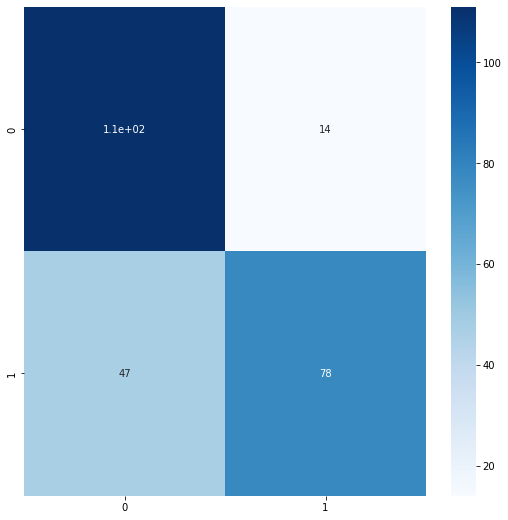

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# ResNet50

## Build Model

In [19]:
# create ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [20]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [21]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('resnet50')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 14:50:35.513178


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.7631 - tp: 185.0000 - fp: 166.0000 - tn: 975.0000 - fn: 475.0000 - BinaryAccuracy: 0.6441 - precision: 0.5271 - recall: 0.2803 - auc: 0.6556
Epoch 00001: val_loss improved from inf to 152827.82812, saving model to model.resnet50.h5
57/57 [==============================] - 24s 263ms/step - loss: 0.7631 - tp: 185.0000 - fp: 166.0000 - tn: 975.0000 - fn: 475.0000 - BinaryAccuracy: 0.6441 - precision: 0.5271 - recall: 0.2803 - auc: 0.6556 - val_loss: 152827.8281 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.4960 - tp: 376.0000 - fp: 166.0000 - tn: 975.0000 - fn: 284.0000 - BinaryAccuracy: 0.7501 - precision: 0.6937 - recall: 0.5697 - auc: 0.8252
Epoch 00002: val_loss improved from 152827.82812 to 0.69514, 

## Evaluate Model

In [22]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 87ms/step - loss: 1.4137 - tp: 98.0000 - fp: 41.0000 - tn: 244.0000 - fn: 67.0000 - BinaryAccuracy: 0.7600 - precision: 0.7050 - recall: 0.5939 - auc: 0.7579


In [23]:
# show results
print('ResNet50:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ResNet50:
---------------
ACCURACY: 0.76
Binary Accuracy: 0.7599999904632568
Precision: 0.7050359845161438
Recall: 0.5939394235610962
AUC: 0.75789475440979
F1 Score: 0.6447368651161541


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80       125
      Stroke       0.94      0.54      0.69       125

    accuracy                           0.76       250
   macro avg       0.81      0.76      0.74       250
weighted avg       0.81      0.76      0.74       250

Confusion Matrix
[[121   4]
 [ 57  68]]


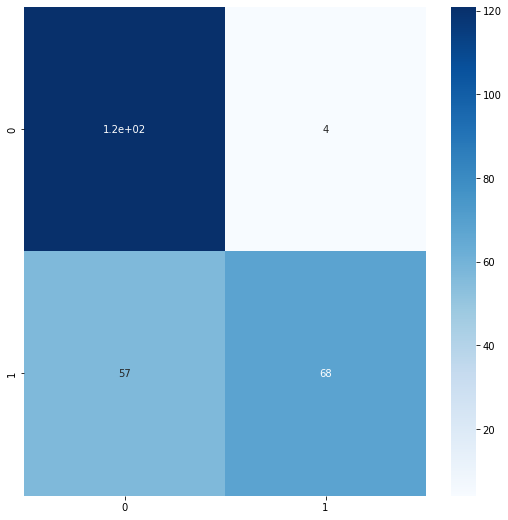

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# VGG16

## Build Model

In [25]:
# create VGG16 base model
base_model = tf.keras.applications.VGG16(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [26]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [27]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vgg16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 15:10:24.274949
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.8288 - tp: 18.0000 - fp: 37.0000 - tn: 1104.0000 - fn: 642.0000 - BinaryAccuracy: 0.6230 - precision: 0.3273 - recall: 0.0273 - auc: 0.5016
Epoch 00001: val_loss improved from inf to 0.66633, saving model to model.vgg16.h5
57/57 [==============================] - 23s 281ms/step - loss: 0.8288 - tp: 18.0000 - fp: 37.0000 - tn: 1104.0000 - fn: 642.0000 - BinaryAccuracy: 0.6230 - precision: 0.3273 - recall: 0.0273 - auc: 0.5016 - val_loss: 0.6663 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7008 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.6645 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1141.0000 - fn: 660.0000 - BinaryAccuracy: 0.6335 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5109
Epoch 00002: val_loss improved from 

## Evaluate Model

In [28]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 85ms/step - loss: 1.0015 - tp: 53.0000 - fp: 40.0000 - tn: 245.0000 - fn: 112.0000 - BinaryAccuracy: 0.6622 - precision: 0.5699 - recall: 0.3212 - auc: 0.6659


In [29]:
# show results
print('VGG16:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

VGG16:
---------------
ACCURACY: 0.6622222222222223
Binary Accuracy: 0.6622222065925598
Precision: 0.5698924660682678
Recall: 0.32121211290359497
AUC: 0.6659010648727417
F1 Score: 0.41085270454975126


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.50      0.88      0.64       125
      Stroke       0.52      0.13      0.21       125

    accuracy                           0.50       250
   macro avg       0.51      0.50      0.42       250
weighted avg       0.51      0.50      0.42       250

Confusion Matrix
[[110  15]
 [109  16]]


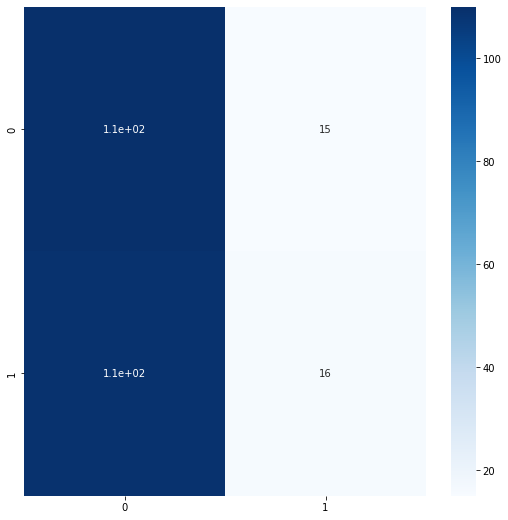

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# InceptionV3

## Build Model

In [31]:
INPUT_SHAPE = (299, 299, 3)

# create InceptionV3 base model
base_model = tf.keras.applications.InceptionV3(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

87924736/87910968 [==============================] - 3s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                

In [32]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [33]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('inceptionv3')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 15:32:39.945444
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.7139 - tp: 240.0000 - fp: 220.0000 - tn: 921.0000 - fn: 420.0000 - BinaryAccuracy: 0.6446 - precision: 0.5217 - recall: 0.3636 - auc: 0.6247
Epoch 00001: val_loss improved from inf to 1.38962, saving model to model.inceptionv3.h5
57/57 [==============================] - 25s 251ms/step - loss: 0.7139 - tp: 240.0000 - fp: 220.0000 - tn: 921.0000 - fn: 420.0000 - BinaryAccuracy: 0.6446 - precision: 0.5217 - recall: 0.3636 - auc: 0.6247 - val_loss: 1.3896 - val_tp: 113.0000 - val_fp: 165.0000 - val_tn: 120.0000 - val_fn: 52.0000 - val_BinaryAccuracy: 0.5178 - val_precision: 0.4065 - val_recall: 0.6848 - val_auc: 0.5772 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.3785 - tp: 472.0000 - fp: 116.0000 - tn: 1025.0000 - fn: 188.0000 - BinaryAccuracy: 0.8312 - precision: 0.8027 - recall: 0.7152 - auc: 0.9018
Epoch 00002: val_loss did not improve from 1.38962
57

## Evaluate Model

In [34]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 85ms/step - loss: 1.8314 - tp: 69.0000 - fp: 24.0000 - tn: 261.0000 - fn: 96.0000 - BinaryAccuracy: 0.7333 - precision: 0.7419 - recall: 0.4182 - auc: 0.7022


In [35]:
# show results
print('InceptionV3:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

InceptionV3:
---------------
ACCURACY: 0.7333333333333333
Binary Accuracy: 0.7333333492279053
Precision: 0.7419354915618896
Recall: 0.41818180680274963
AUC: 0.7022327184677124
F1 Score: 0.534883713620685


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.66      0.94      0.78       125
      Stroke       0.90      0.51      0.65       125

    accuracy                           0.73       250
   macro avg       0.78      0.73      0.71       250
weighted avg       0.78      0.73      0.71       250

Confusion Matrix
[[118   7]
 [ 61  64]]


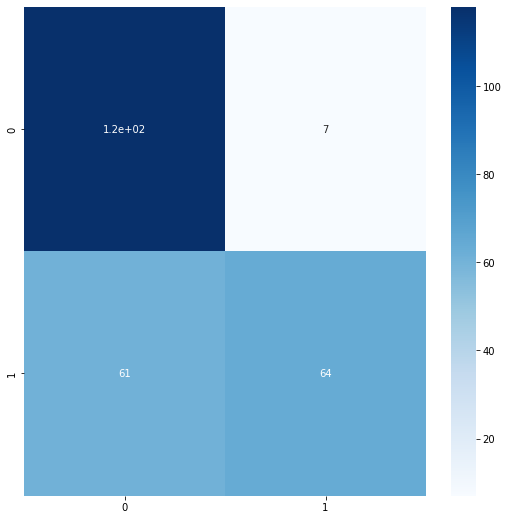

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# MobileNet

## Build Model

In [37]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# create MobileNet base model
base_model = tf.keras.applications.MobileNet(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128  

In [38]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [39]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('mobilenet')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 15:49:32.629907
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.4764 - tp: 473.0000 - fp: 163.0000 - tn: 978.0000 - fn: 187.0000 - BinaryAccuracy: 0.8057 - precision: 0.7437 - recall: 0.7167 - auc: 0.8727
Epoch 00001: val_loss improved from inf to 1.50060, saving model to model.mobilenet.h5
57/57 [==============================] - 16s 211ms/step - loss: 0.4764 - tp: 473.0000 - fp: 163.0000 - tn: 978.0000 - fn: 187.0000 - BinaryAccuracy: 0.8057 - precision: 0.7437 - recall: 0.7167 - auc: 0.8727 - val_loss: 1.5006 - val_tp: 31.0000 - val_fp: 34.0000 - val_tn: 251.0000 - val_fn: 134.0000 - val_BinaryAccuracy: 0.6267 - val_precision: 0.4769 - val_recall: 0.1879 - val_auc: 0.5832 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.2067 - tp: 587.0000 - fp: 61.0000 - tn: 1080.0000 - fn: 73.0000 - BinaryAccuracy: 0.9256 - precision: 0.9059 - recall: 0.8894 - auc: 0.9711
Epoch 00002: val_loss improved from 1.50060 to 0.75104, sa

## Evaluate Model

In [40]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 81ms/step - loss: 2.1088 - tp: 74.0000 - fp: 30.0000 - tn: 255.0000 - fn: 91.0000 - BinaryAccuracy: 0.7311 - precision: 0.7115 - recall: 0.4485 - auc: 0.7257


In [41]:
# show results
print('MobileNet:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

MobileNet:
---------------
ACCURACY: 0.7311111111111112
Binary Accuracy: 0.7311111092567444
Precision: 0.7115384340286255
Recall: 0.4484848380088806
AUC: 0.7256884574890137
F1 Score: 0.5501858574990779


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.64      0.86      0.73       125
      Stroke       0.78      0.51      0.62       125

    accuracy                           0.68       250
   macro avg       0.71      0.68      0.67       250
weighted avg       0.71      0.68      0.67       250

Confusion Matrix
[[107  18]
 [ 61  64]]


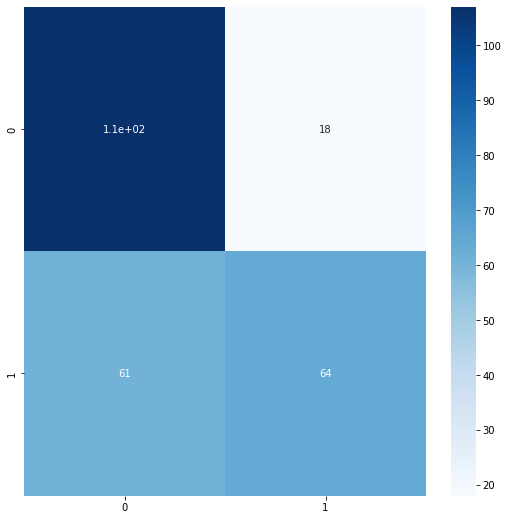

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# ViT B16

## Build Model

In [43]:
# build vit model with 16 patch_size
base_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = tf.keras.layers.Flatten()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

347512832/347502902 [==============================] - 15s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [44]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [45]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 16:06:20.473117
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.6295 - tp: 272.0000 - fp: 229.0000 - tn: 912.0000 - fn: 388.0000 - BinaryAccuracy: 0.6574 - precision: 0.5429 - recall: 0.4121 - auc: 0.6793
Epoch 00001: val_loss improved from inf to 0.72820, saving model to model.vitb16.h5
57/57 [==============================] - 85s 944ms/step - loss: 0.6295 - tp: 272.0000 - fp: 229.0000 - tn: 912.0000 - fn: 388.0000 - BinaryAccuracy: 0.6574 - precision: 0.5429 - recall: 0.4121 - auc: 0.6793 - val_loss: 0.7282 - val_tp: 30.0000 - val_fp: 10.0000 - val_tn: 275.0000 - val_fn: 135.0000 - val_BinaryAccuracy: 0.6778 - val_precision: 0.7500 - val_recall: 0.1818 - val_auc: 0.7298 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.3363 - tp: 501.0000 - fp: 109.0000 - tn: 1032.0000 - fn: 159.0000 - BinaryAccuracy: 0.8512 - precision: 0.8213 - recall: 0.7591 - auc: 0.9250
Epoch 00002: val_loss did not improve from 0.72820
57/57 [=

## Evaluate Model

In [46]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 4s 245ms/step - loss: 2.6244 - tp: 88.0000 - fp: 56.0000 - tn: 229.0000 - fn: 77.0000 - BinaryAccuracy: 0.7044 - precision: 0.6111 - recall: 0.5333 - auc: 0.6798


In [47]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.7044444444444444
Binary Accuracy: 0.7044444680213928
Precision: 0.6111111044883728
Recall: 0.5333333611488342
AUC: 0.6797555685043335
F1 Score: 0.5695793010116753


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.69      0.93      0.79       125
      Stroke       0.89      0.58      0.71       125

    accuracy                           0.76       250
   macro avg       0.79      0.76      0.75       250
weighted avg       0.79      0.76      0.75       250

Confusion Matrix
[[116   9]
 [ 52  73]]


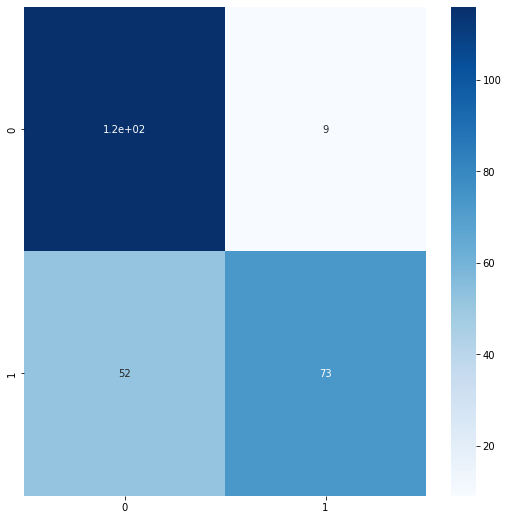

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# ViT B32

## Build Model

In [49]:
# build vit model with 32 patch_size
base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = tf.keras.layers.Flatten()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

353263616/353253686 [==============================] - 17s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_1 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [50]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [51]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-21 17:26:03.141275
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.6840 - tp: 266.0000 - fp: 267.0000 - tn: 874.0000 - fn: 394.0000 - BinaryAccuracy: 0.6330 - precision: 0.4991 - recall: 0.4030 - auc: 0.6205
Epoch 00001: val_loss improved from inf to 0.75285, saving model to model.vitb32.h5
57/57 [==============================] - 53s 399ms/step - loss: 0.6840 - tp: 266.0000 - fp: 267.0000 - tn: 874.0000 - fn: 394.0000 - BinaryAccuracy: 0.6330 - precision: 0.4991 - recall: 0.4030 - auc: 0.6205 - val_loss: 0.7529 - val_tp: 11.0000 - val_fp: 15.0000 - val_tn: 270.0000 - val_fn: 154.0000 - val_BinaryAccuracy: 0.6244 - val_precision: 0.4231 - val_recall: 0.0667 - val_auc: 0.5672 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.3778 - tp: 483.0000 - fp: 128.0000 - tn: 1013.0000 - fn: 177.0000 - BinaryAccuracy: 0.8306 - precision: 0.7905 - recall: 0.7318 - auc: 0.9042
Epoch 00002: val_loss did not improve from 0.75285
57/57 [=

## Evaluate Model

In [52]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 96ms/step - loss: 2.5965 - tp: 56.0000 - fp: 23.0000 - tn: 262.0000 - fn: 109.0000 - BinaryAccuracy: 0.7067 - precision: 0.7089 - recall: 0.3394 - auc: 0.6364


In [53]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.7066666666666667
Binary Accuracy: 0.7066666483879089
Precision: 0.7088607549667358
Recall: 0.3393939435482025
AUC: 0.6364062428474426
F1 Score: 0.45901639629290547


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.66      0.97      0.79       125
      Stroke       0.94      0.51      0.66       125

    accuracy                           0.74       250
   macro avg       0.80      0.74      0.73       250
weighted avg       0.80      0.74      0.73       250

Confusion Matrix
[[121   4]
 [ 61  64]]


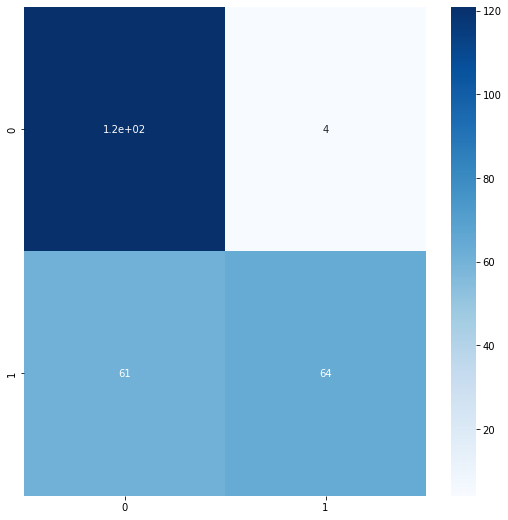

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)